# Trigger Word Detection

In this video you will construct a speech dataset and implement an algorithm for trigger word detection (sometimes also called keyword detection, or wake word detection). 

* Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.  
* For this exercise, our trigger word will be "robo".

<img src="images/sound.png" style="width:1000px;height:150px;">

Let's get started!

# Packages

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from trigger_util import *
%matplotlib inline

C:\Users\userH\anaconda3\envs\TFGPU\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## 1 - Data synthesis: Creating a Speech Dataset 

Let's start by building a dataset for your trigger word detection algorithm. 
* A speech dataset should ideally be as close as possible to the application you will want to run it on. 
* In this case, you'd like to detect the word "robo". 
* Therefore, you need to create recordings with a mix of positive words ("robo") and negative words (random words other than activate) on different background sounds. Let's see how you can create such a dataset. 

<a name='1-1'></a>
### 1.1 - Listening to the Data   

* One of your friends is helping you out on this project, and they've gone to libraries, cafes, restaurants, homes and offices all around the region to record background noises, as well as snippets of audio of people saying positive/negative words. This dataset includes people speaking in a variety of accents. 

Run the cells below to listen to some examples.

In [2]:
IPython.display.Audio("data_set/bk/chunk_024.wav",rate=16000)

In [3]:
IPython.display.Audio("data_set/dd/detect (13).wav",rate=16000)

In [4]:
IPython.display.Audio("data_set/RW/random (27).wav",rate=16000)

### 1.2 - From Audio Recordings to Spectrograms

What really is an audio recording? 
* A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. 
* You can think of an audio recording as a long list of numbers measuring the little air pressure changes detected by the microphone. 
* We will use audio sampled at 16000 Hz (or 16000 Hertz). 
    * This means the microphone gives us 16,000 numbers per second. 

#### Spectrogram
* It is quite difficult to figure out from this "raw" representation of audio whether the word "robo" was said. 
* In  order to help your sequence model more easily learn to detect trigger words, we will compute a *spectrogram* of the audio. 
* The spectrogram tells us how much different frequencies are present in an audio clip at any moment in time. 
* If you've ever taken an advanced class on signal processing or on Fourier transforms:
    * A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform. 
    * If you don't understand the previous sentence, don't worry about it.

Let's look at an example. 

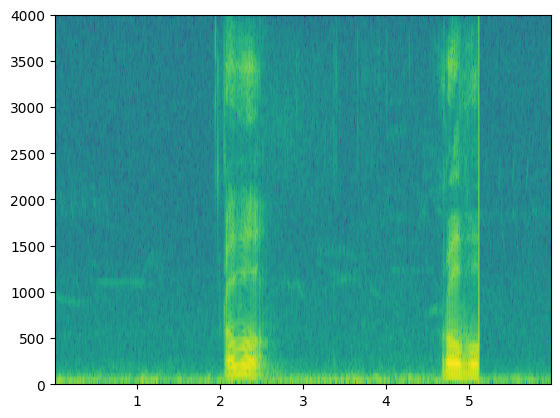

In [5]:
x = graph_spectrogram("train_1.wav")

In [6]:
_, data = wavfile.read("data_set/Back_Ground/chunk_373.wav")
print("Time steps in audio recording before spectrogram", data.shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (48000,)
Time steps in input after spectrogram (101, 598)


In [10]:
Tx = 598 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [11]:
Ty = 146 # The number of time steps in the output of our model

### 1.3 - Generating a Single Training Example

#### Benefits of synthesizing data
Because speech data is hard to acquire and label, you will synthesize your training data using the audio clips of robo, negatives, and backgrounds. 
* It is quite slow to record lots of 3 second audio clips with random "robo" in it. 
* Instead, it is easier to record lots of positives and negative words, and record background noise separately (or download background noise from free online sources). 

#### Process for Synthesizing an audio clip
* To synthesize a single training example, you will:
    - Pick a random 3 second background audio clip
    - Randomly insert 0-4 audio clips of "activate" into this 3 sec. clip
    - Randomly insert 0-2 audio clips of negative words into this 3 sec. clip
* Because you had synthesized the word "robo" into the background clip, you know exactly when in the 3 second clip the "robo" makes its appearance. 
    * You'll see later that this makes it easier to generate the labels $y^{\langle t \rangle}$ as well. 

#### Pydub
* You will use the pydub package to manipulate audio. 
* Pydub converts raw audio files into lists of Pydub data structures.
    * Don't worry about the details of the data structures.
* Pydub uses 1ms as the discretization interval (1 ms is 1 millisecond = 1/1000 seconds).
    * This is why a 3 second clip is always represented using 3,000 steps. 

In [17]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('data_set/')

print("background len should be 3,000, since it is a 3 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 3,000, since it is a 3 sec clip
3000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
1728 

activate[1] len: different `activate` clips can have different lengths
768 



#### Overlaying positive/negative 'word' audio clips on top of the background audio

* Given a 3 second background clip and a short audio clip containing a positive or negative word, you need to be able to "add" the word audio clip on top of the background audio.
* You will be inserting multiple clips of positive/negative words into the background, and you don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added. 
    * To ensure that the 'word' audio segments do not overlap when inserted, you will keep track of the times of previously inserted audio clips. 
* To be clear, when you insert a 1 second "activate" onto a 3 second clip of cafe noise, **you do not end up with an 4 sec clip.** 
    * The resulting audio clip is still 3 seconds long.
    * You'll see later how pydub allows you to do this. 

#### Label the positive/negative words
* Recall that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "robo". 
    * $y^{\langle t \rangle} = 1$ when that clip has finished saying "robo".
    * Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "robo". 
* When you insert or overlay an "activate" clip, you will also update labels for $y^{\langle t \rangle}$.
    * Rather than updating the label of a single time step, we will update 10 steps of the output to have target label 1. 
    * Recall from the lecture on trigger word detection that updating several consecutive time steps can make the training data more balanced.
* You will train a GRU (Gated Recurrent Unit) to detect when someone has **finished** saying "activate". 

##### Example
* Suppose the synthesized "robo" clip ends at the 1.5 second mark in the 3 second audio - exactly halfway into the clip. 
* Recall that $T_y = 147$, so timestep $73 = $ `int(147*0.5)` corresponds to the moment 1.5 seconds into the audio clip. 
* Set $y^{\langle 74 \rangle} = 1$. 
* We will allow the GRU to detect "robo" anywhere within a short time-internal **after** this moment, so we actually **set 10 consecutive values** of the label $y^{\langle t \rangle}$ to 1. 
    * Specifically, we have $y^{\langle 74 \rangle} = y^{\langle 75 \rangle} = \cdots = y^{\langle 83 \rangle} = 1$.  

##### Synthesized data is easier to label
* This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. 
* In contrast, if you have 3sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "robo" finished. 

#### Visualizing the labels
* Here's a figure illustrating the labels $y^{\langle t \rangle}$ in a clip.
    * We have inserted "activate", "innocent", "activate", "baby." 
    * Note that the positive labels "1" are associated only with the positive words. 

<img src="images/label_diagram.png" style="width:500px;height:200px;">
<center> Figure 2 </center>


#### Helper functions

To implement the training set synthesis process, you will use the following helper functions. 
* All of these functions will use a 1ms discretization interval
* The 3 seconds of audio is always discretized into 3,000 steps. 


1. `get_random_time_segment(segment_ms)`
    * Retrieves a random time segment from the background audio.
2. `is_overlapping(segment_time, existing_segments)`
    * Checks if a time segment overlaps with existing segments
3. `insert_audio_clip(background, audio_clip, existing_times)`
    * Inserts an audio segment at a random time in the background audio
    * Uses the functions `get_random_time_segment` and `is_overlapping`
4. `insert_ones(y, segment_end_ms)`
    * Inserts additional 1's into the label vector y after the word "robo"

#### Get a random time segment

* The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. 
* Please read through the code to make sure you understand what it is doing. 

In [18]:
def get_random_time_segment(segment_ms):
    segment_start=np.random.randint(low=0,high=3000-segment_ms)
    segment_end = segment_start+segment_ms -1
    return(segment_start,segment_end)

#### Check if audio clips are overlapping

* Suppose you have inserted audio clips at segments (1000,1800) and (3400,4500).
    * The first segment starts at step 1000 and ends at step 1800. 
    * The second segment starts at 3400 and ends at 4500.
* If we are considering whether to insert a new audio clip at (3000,3600) does this overlap with one of the previously inserted segments? 
    * In this case, (3000,3600) and (3400,4500) overlap, so we should decide against inserting a clip here.
* For the purpose of this function, define (100,200) and (200,250) to be overlapping, since they overlap at timestep 200. 
* (100,199) and (200,250) are non-overlapping. 

<a name='ex-1'></a>
### is_overlapping()

* Implement `is_overlapping(segment_time, existing_segments)` to check if a new time segment overlaps with any of the previous segments. 
* You will need to carry out 2 steps:

1. Create a "False" flag, that you will later set to "True" if you find that there is an overlap.
2. Loop over the previous_segments' start and end times. Compare these times to the segment's start and end times. If there is an overlap, set the flag defined in (1) as True. 

You can use:
```python
for ....:
        if ... <= ... and ... >= ...:
            ...
```
Hint: There is overlap if:
* The new segment starts before the previous segment ends **and**
* The new segment ends after the previous segment starts.

In [19]:
def is_overlapping(segment_time, previous_segments):
    start,stop = segment_time
    overlap=False
    for prev_start,prev_stop in previous_segments:
        if start <=prev_stop and end >=prev_start:
            overlap=True
            break
    return overlap

#### Insert audio clip

* Let's use the previous helper functions to insert a new audio clip onto the 3 second background at a random time.
* We will ensure that any newly inserted segment doesn't overlap with previously inserted segments. 

### insert_audio_clip()
* Implement `insert_audio_clip()` to overlay an audio clip onto the background 3 sec clip. 
* We implement 4 steps:

1. Get the length of the audio clip that is to be inserted.
    * Get a random time segment whose duration equals the duration of the audio clip that is to be inserted.
2. Make sure that the time segment does not overlap with any of the previous time segments. 
    * If it is overlapping, then go back to step 1 and pick a new time segment.
3. Append the new time segment to the list of existing time segments
    * This keeps track of all the segments you've inserted.  
4. Overlay the audio clip over the background using pydub. We have implemented this for you.

In [20]:
def insert_audio_clip(background, audio_clip, previous_segments):
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    retry = 7
    while is_overlapping(segment_time,previous_segments) and retry >=0:
        segment_time = get_random_time_segment(segment_ms)
        retry-=1
    if not is_overlapping(segment_time,previous_segments):
        previous_segments.append(segment_ms)
        new_background = background.overlay(audio_clip,position=  segment_time[0])
        print(segment_time)
    else:
        print('Timed Out')
        new_background=background
    return new_background, segment_time
    

#### Insert ones for the labels of the positive target

* Implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted a "robo" audio clip.
* In the code below, `y` is a `(1,147)` dimensional vector, since $T_y = 147$. 
* If the "activate" audio clip ends at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ and also set the next 9 additional consecutive values to 1.
    * Notice that if the target word appears near the end of the entire audio clip, there may not be 10 additional time steps to set to 1.
    * Make sure you don't run off the end of the array and try to update `y[0][147]`, since the valid indices are `y[0][0]` through `y[0][146]` because $T_y = 147$. 
    * So if "robo" ends at step 143, you would get only set `y[0][143] = y[0][144] = y[0][145] = y[0][146] = 1`

### insert_ones()
Implement `insert_ones()`. 
* You can use a for loop. 
* If you want to use Python's array slicing operations, you can do so as well.
* If a segment ends at `segment_end_ms` (using a 3000 step discretization),
    * To convert it to the indexing for the outputs $y$ (using a $147$ step discretization), we will use this formula:  
```
    segment_end_y = int(segment_end_ms * Ty / 3000.0)

In [21]:
def insert_ones(y, segment_end_ms):
    _,Ty=y.shape
    segment_end_y = int(segment_end_ms * Ty /3000)
    if segment_end_y <Ty :
        for i in range (segment_end_y+1,segment_end_y+11):
            if (i<Ty):
                y[0,i]=1
    return y
    

#### Creating a training example
Finally, you can use `insert_audio_clip` and `insert_ones` to create a new training example.

### create_training_example ()

Implement `create_training_example()`. You will need to carry out the following steps:

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 3 "activate" audio clips, and insert them onto the 3 second clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 3 second clip. 


In [22]:
def create_training_example(background, activates, negatives, Ty):
    background = background - 20
    y=np.zeros ((1,Ty))
    previous_segments = [] 
    number_active = np.random.randint(0,3) 
    random_inds = np.random.randint (len(activates),size =  number_active)
    random_activ = [activates[i] for i in random_inds]
    for rand_act in random_activ:
        background,segment_time = insert_audio_clip(background,rand_act,previous_segments)
        _,seg_end=segment_time
        y=insert_ones(y,seg_end)
    number_neagative = np.random.randint(0,2) 
    random_inds = np.random.randint (len(negatives),size =  number_negative)
    random_activ = [activates[i] for i in random_inds]
    for rand_act in random_activ:
        background,_ = insert_audio_clip(background,rand_act,previous_segments)
    background = match_target_amplitude(background,-20.0)
    x=compute_spectrgram(background,fs=16000)
    return x,y 

### 1.4 - Full Training Set

* You've now implemented the code needed to generate a single training example. 
* We used this process to generate a large training set. 

In [ ]:
np.random.seed(4543)
nsamples = 1346
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X=np.array(X)
Y=np.array(Y)

## 2 - The Model

* Now that you've built a dataset, let's write and train a trigger word detection model! 
* The model will use 1-D convolutional layers, GRU layers, and dense layers. 
* Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

### 2.1 - Build the Model

Our goal is to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. This network will use 4 layers:
    * A convolutional layer
    * Two GRU layers
    * A dense layer. 

Here is the architecture we will use.

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

##### 1D convolutional layer
One key layer of this model is the 1D convolutional step (near the bottom of Figure 3). 
* It inputs the 598 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 147 step output
* This output is further processed by multiple layers to get the final $T_y = 147$ step output. 
* This 1D convolutional layer plays a role similar to the 2D convolutions, of extracting low-level features and then possibly generating an output of a smaller dimension. 
* Computationally, the 1-D conv layer also helps speed up the model because now the GRU  can process only 147 timesteps rather than 598 timesteps. 

##### GRU, dense and sigmoid
* The two GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$. 
* Because $y$ is a binary value (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate".

#### Unidirectional RNN
* Note that we use a **unidirectional RNN** rather than a bidirectional RNN. 
* This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. 
* If we used a bidirectional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [24]:
def modelf(input_shape):
    X_input=Input(sahpe = input_shape)
    X= Conv1D(filters=196,kernel_size=15,strides=4)(X_input)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X=Dropout(0.8)(X)
    X=GRU(units=128,return_sequences=True)(X)
    X=Dropout(0.8)(X)    
    X=BatchNormalization()(X)
    X=GRU(units=128,return_sequences=True)(X)
    X=Dropout(0.8)(X)    
    X=BatchNormalization()(X)
    X=Dropout(0.8)(X)    
    X=TimeDistributed(Dense(1,activation='sigmoid'))(X)
    model = Model (Inputs=X_inputs,outputs = X)
    return model

In [25]:
model = modelf(input_shape = (Tx, n_freq))

ValueError: Please provide to Input a `shape` or a `tensor` or a `type_spec` argument. Note that `shape` does not include the batch dimension.

In [ ]:
model.summary()

In [ ]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
checkpoint_path = "model_checkpoints/model.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, 
                                                         save_freq='epoch',  # Save every epoch
                                                         verbose=1)

In [ ]:
model.fit(X, Y,epochs=2500,callbacks=[checkpoint_callback])

In [26]:
 model.load_weights('model_weights.h5')

NameError: name 'model' is not defined

# 3-Live Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def compute_spectrogram(audio_segment, fs=16000):
    """
    Compute the spectrogram of the given audio segment.
    - audio_segment: 1D NumPy array of audio samples.
    - fs: Sampling rate in Hz (default 16,000).
    
    Returns:
    - pxx: Spectrogram data
    - freqs: Frequency bins
    - times: Time bins
    """
    nfft = 200  # Length of each window segment
    noverlap = 120  # Overlap between windows

    freqs, times, pxx = signal.spectrogram(audio_segment, fs=fs, nperseg=nfft, noverlap=noverlap)

    return pxx


In [ ]:
import numpy as np
import pyaudio
import time
import tensorflow as tf

# Parameters for real-time audio processing
CHUNK = 1024
RATE = 16000
WINDOW_DURATION = 3  # 3 seconds window
STEP_DURATION = 2    # 2 seconds step (1 sec overlap)
window_size = int(RATE * WINDOW_DURATION)
step_size = int(RATE * STEP_DURATION)

# Initialize audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)

# Initialize buffer
buffer = np.zeros(window_size, dtype=np.int16)

# Load trained model
#model = tf.keras.models.load_model("your_model_path.h5")  # Change to actual model path

def process_audio_segment(segment):
    """
    Compute the spectrogram and pass it to the model.
    Return a binary vector (0s and 1s).
    """
    pxx = compute_spectrogram(segment, fs=RATE)
    pxx = np.transpose(pxx)  # Now shape is (101, 598)

    # Normalize and reshape spectrogram for model input
    spectrogram = np.expand_dims(pxx, axis=0)  # Shape (1, height, width, 1)

    # Run inference
    output = model.predict(spectrogram)  # Model outputs probabilities
    return np.sum( output)

# Detection threshold
DETECTION_THRESHOLD = 9  # Adjust based on testing

print("Listening for the trigger word...")

try:
    while True:
        # Read new data from the stream
        new_data = stream.read(step_size, exception_on_overflow=False)
        new_samples = np.frombuffer(new_data, dtype=np.int16)
        
        # Update buffer
        buffer = np.roll(buffer, -len(new_samples))
        buffer[-len(new_samples):] = new_samples
        
        # Process the buffer
        output_vector = process_audio_segment(buffer)
        if output_vector >= DETECTION_THRESHOLD:
            print("Trigger word detected!")

except KeyboardInterrupt:
    print("Stopping...")
finally:
    stream.stop_stream()
    stream.close()
    p.terminate()
